# Exploration Regression Exercises:

Our Zillow scenario continues:

As a Codeup data science graduate, you want to show off your skills to the Zillow data science team in hopes of getting an interview for a position you saw pop up on LinkedIn. You thought it might look impressive to build an end-to-end project in which you use some of their Kaggle data to predict property values using some of their available features; who knows, you might even do some feature engineering to blow them away. Your goal is to predict the values of single unit properties using the observations from 2017.

In these exercises, you will run through the stages of exploration as you continue to work toward the above goal.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

import env
from wrangle import wrangle_zillow
import prepare

### Exercise 1) 
As with encoded vs. unencoded data, we recommend exploring un-scaled data in your EDA process.


In [2]:
df = wrangle_zillow()

In [3]:
#double-checking dtypes
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2094570 entries, 0 to 2094569
Data columns (total 7 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   bedroomcnt                    int64  
 1   bathroomcnt                   float64
 2   calculatedfinishedsquarefeet  int64  
 3   taxvaluedollarcnt             int64  
 4   yearbuilt                     int64  
 5   taxamount                     float64
 6   fips                          int64  
dtypes: float64(2), int64(5)
memory usage: 127.8 MB


In [4]:
#double checking any nulls not caught
df.isnull().sum()

bedroomcnt                      0
bathroomcnt                     0
calculatedfinishedsquarefeet    0
taxvaluedollarcnt               0
yearbuilt                       0
taxamount                       0
fips                            0
dtype: int64

In [5]:
#looking at the count of each column variable
for column in df.columns:
    print(column)
    print(df[column].value_counts())
    print("-----------------")

bedroomcnt
3    955905
4    621073
2    332537
5    138253
1     22723
6     19800
0      4279
Name: bedroomcnt, dtype: int64
-----------------
bathroomcnt
2.00    940252
3.00    416450
1.00    412087
2.50    142178
4.00     74212
1.50     31112
3.50     26777
5.00     20923
4.50     16820
6.00      5412
0.00      4180
5.50      4151
0.50        13
1.75         3
Name: bathroomcnt, dtype: int64
-----------------
calculatedfinishedsquarefeet
1200    5182
1080    4372
1120    4350
1400    3822
1440    3681
        ... 
54         1
8262       1
6444       1
7864       1
7026       1
Name: calculatedfinishedsquarefeet, Length: 7143, dtype: int64
-----------------
taxvaluedollarcnt
450000     820
500000     772
400000     722
430000     689
440000     682
          ... 
122086       1
231332       1
1131381      1
999493       1
536061       1
Name: taxvaluedollarcnt, Length: 557429, dtype: int64
-----------------
yearbuilt
1955    83828
1950    70957
1954    68596
1953    61834
1956    61

bedroomcnt


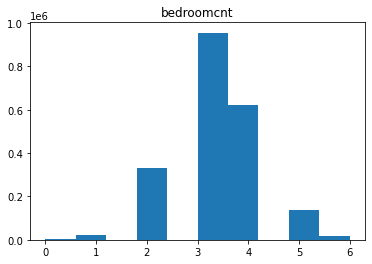

bathroomcnt


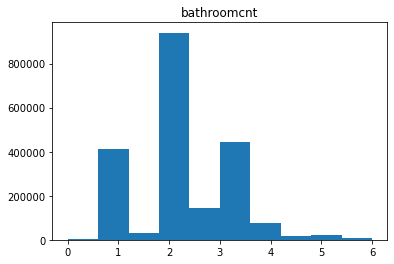

calculatedfinishedsquarefeet


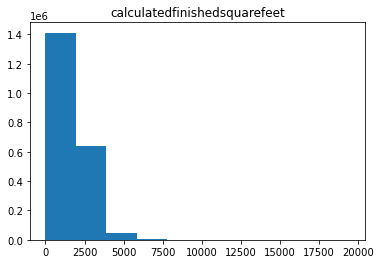

taxvaluedollarcnt


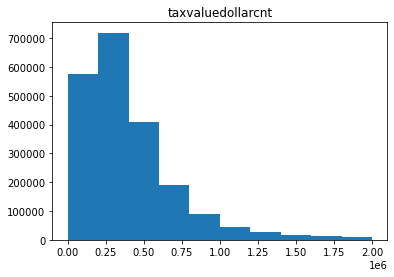

yearbuilt


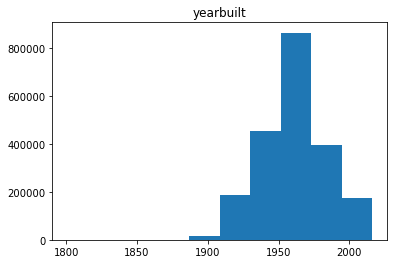

taxamount


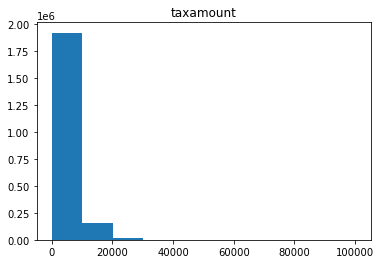

fips


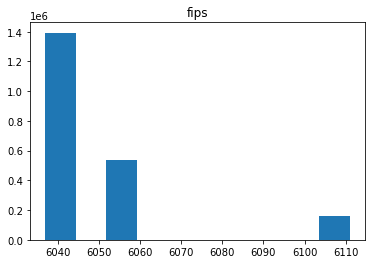

In [6]:
#Univariate plots: (Histograms of each column variable)
for col in df.columns:
    print(col)
    plt.title(col)
    df[col].hist()
    plt.grid(False)
    plt.show()

In [7]:
#looking at means and std of numeric variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,2094570.0,3.270298,0.890559,0.00,3.00,3.00,4.0000,6.00
bathroomcnt,2094570.0,2.181947,0.875977,0.00,2.00,2.00,3.0000,6.00
calculatedfinishedsquarefeet,2094570.0,1796.820984,787.712298,1.00,1250.00,1607.00,2159.0000,19460.00
taxvaluedollarcnt,2094570.0,398619.663857,313505.297081,22.00,185937.00,322168.00,516761.0000,1999995.00
yearbuilt,2094570.0,1960.662379,21.863654,1801.00,1949.00,1958.00,1975.0000,2016.00
taxamount,2094570.0,4909.452668,3639.363826,6.34,2506.64,4040.14,6210.6275,100379.34
fips,2094570.0,6048.373624,20.432690,6037.00,6037.00,6037.00,6059.0000,6111.00


### Takeaways:
- Noticing that the mean of our main components (bedroom count, bathroom count and value) are:
    * <b>3bd 2ba | house value= $398,619 | 1796 sqft</b>

- Fips is 3 counties that can be broken down into either their own (maybe own models?) and I'd like to explore the means of those seperately


In [8]:
#using a function to set the Fips codes into their different counties.
def clearing_fips(df):
    '''This function takes in a DataFrame of unprepared Zillow information and generates a new
    'county' column, with the county name based on the FIPS code. 
    '''
    # create a list of our conditions
    fips = [
        (df['fips'] == 6037),
        (df['fips'] == 6059),
        (df['fips'] == 6111)
        ]
    # create a list of the values we want to assign for each condition
    counties = ['Los Angeles County', 'Orange County', 'Ventura County']
    # create a new column and use np.select to assign values to it using our lists as arguments
    df['county'] = np.select(fips, counties)
    return df

In [9]:
#using the new function:
clearing_fips(df)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,county
0,4,2.0,3633,296425,2005,6941.39,6037,Los Angeles County
1,3,4.0,1620,847770,2011,10244.94,6037,Los Angeles County
2,3,2.0,2077,646760,1926,7924.68,6037,Los Angeles County
3,0,0.0,1200,5328,1972,91.60,6037,Los Angeles County
4,0,0.0,171,6920,1973,255.17,6037,Los Angeles County
...,...,...,...,...,...,...,...,...
2094565,4,4.0,4375,422400,2015,13877.56,6037,Los Angeles County
2094566,4,3.0,2262,960756,2015,13494.52,6059,Orange County
2094567,4,4.5,3127,536061,2014,6244.16,6059,Orange County
2094568,3,2.5,1974,424353,2015,5302.70,6059,Orange County


In [10]:
df.head()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,county
0,4,2.0,3633,296425,2005,6941.39,6037,Los Angeles County
1,3,4.0,1620,847770,2011,10244.94,6037,Los Angeles County
2,3,2.0,2077,646760,1926,7924.68,6037,Los Angeles County
3,0,0.0,1200,5328,1972,91.60,6037,Los Angeles County
4,0,0.0,171,6920,1973,255.17,6037,Los Angeles County


### Exercise 2) Make sure to perform a train, validate, test split 
before and use only your train dataset to explore the relationships between independent variables with other independent variables or independent variables with your target variable.

### Splitting the Data:

In [11]:
#using function found in wrangle.py file
train, validate, test = prepare.split_data(df)

train

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount,fips,county
584465,3,3.0,1558,548235,1992,6239.72,6059,Orange County
191552,3,2.0,1764,719944,1941,8660.63,6037,Los Angeles County
868542,3,2.0,1368,573616,1964,5857.00,6059,Orange County
1459105,2,2.0,1155,576041,1950,7484.74,6037,Los Angeles County
417535,2,1.0,903,181259,1921,2289.50,6059,Orange County
...,...,...,...,...,...,...,...,...
143897,3,1.5,1198,51782,1954,831.44,6059,Orange County
1194932,4,2.5,2017,250604,1979,3239.92,6111,Ventura County
1706472,4,2.5,2503,428686,1990,4285.88,6059,Orange County
1092256,4,2.0,1390,303030,1956,3864.59,6037,Los Angeles County


### Univariate Plots:
Looking at the variables from a visual lens.

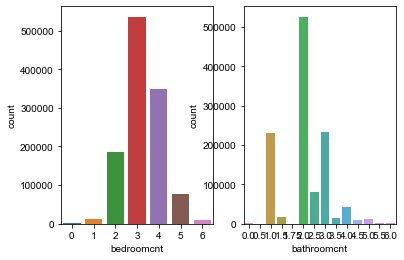

In [12]:
#Looking at discrete values of Bedroom count and Bathroom count
fig, ax =plt.subplots(1,2)
sns.countplot(train['bedroomcnt'], ax=ax[0])
sns.countplot(train['bathroomcnt'], ax=ax[1])
sns.set(rc = {'figure.figsize':(12,8)})
fig.show()

#### TAKEAWAYS: I felt that these visualizations showed the mean values well of both bathroom count & bedroom count
- Bathroom Count: making it anything above 0.5 baths and under 5.5 baths. 
- Bedroom Count: taking out the 0 bedroom data

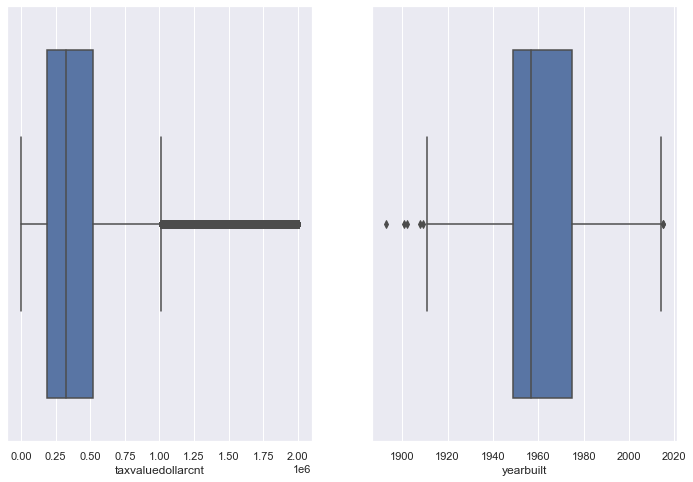

In [13]:
#Looking at continous values of year built
fig, ax =plt.subplots(1,2)
sns.boxplot(x=train["taxvaluedollarcnt"], ax=ax[0])
sns.boxplot(train.sample(1000)['yearbuilt'], ax=ax[1])
sns.set(rc = {'figure.figsize':(12,8)})
fig.show()

#NOTE: will be treating year built as continous, so I can try running a correlation on yearbuilt 

### Exercise 3)
Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

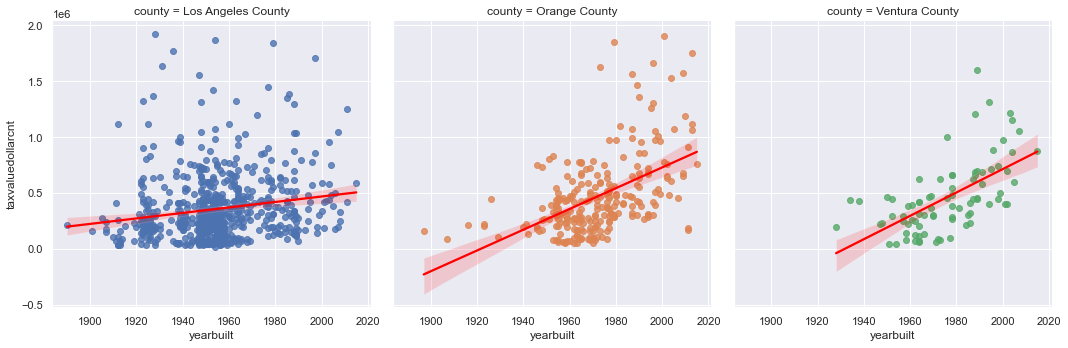

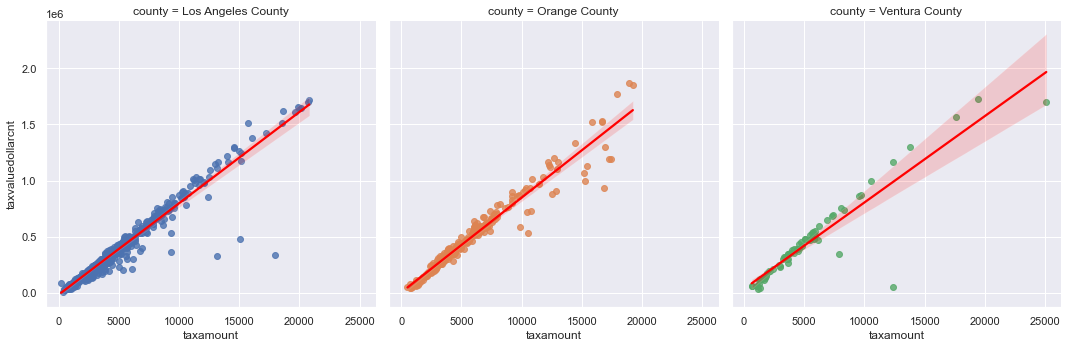

In [14]:
def plot_variable_pairs():
    columns = ['yearbuilt','taxamount']
    for col in columns:
        sns.lmplot(x= col, y="taxvaluedollarcnt", data=train.sample(1000), col = 'county', hue = 'county', line_kws={'color': 'red'})
        
plot_variable_pairs()

### Exercise 4)
Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

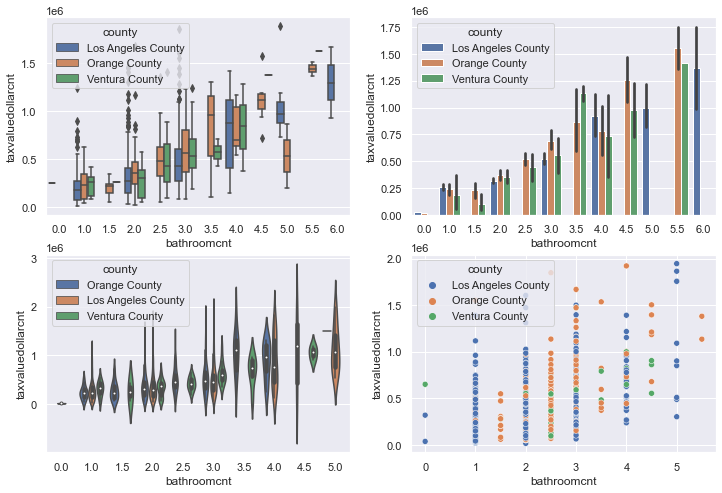

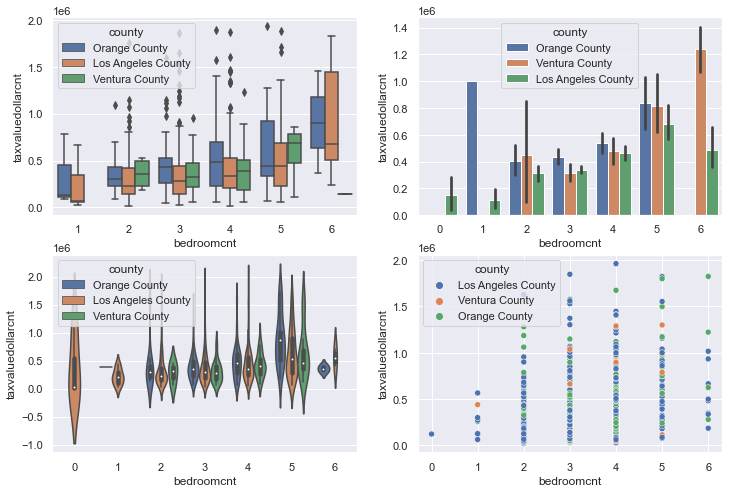

In [15]:
def plot_categorical_and_continuous_vars():
    columns = ['bathroomcnt','bedroomcnt']
    for x in columns:
        sns.set()
        fig, axes = plt.subplots(2,2)
        sns.boxplot(x= x, y="taxvaluedollarcnt", data=train.sample(1000), hue = 'county', ax = axes[0,0])
        sns.barplot(x= x, y="taxvaluedollarcnt", data=train.sample(1000), hue = 'county', ax = axes[0,1])
        sns.violinplot(x= x, y="taxvaluedollarcnt", data=train.sample(1000), hue = 'county', ax = axes[1,0])
        sns.scatterplot(x= x, y="taxvaluedollarcnt", data=train.sample(1000), hue = 'county', ax = axes[1,1])
plot_categorical_and_continuous_vars()
    

Text(0.5, 0.98, 'Categorical & Continous Plotting')

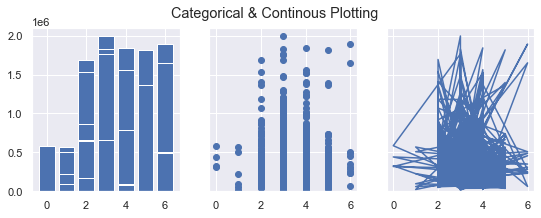

In [16]:
#whoa....weird way of trying this out...

categorical = train.sample(1000).bedroomcnt
y = train.sample(1000).taxvaluedollarcnt

fig, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
axs[0].bar(categorical, y)
axs[1].scatter(categorical, y)
axs[2].plot(categorical, y)
fig.suptitle('Categorical & Continous Plotting')

### Exercise 5):
Save the functions you have written to create visualizations in your explore.py file. Rewrite your notebook code so that you are using the functions imported from this file.

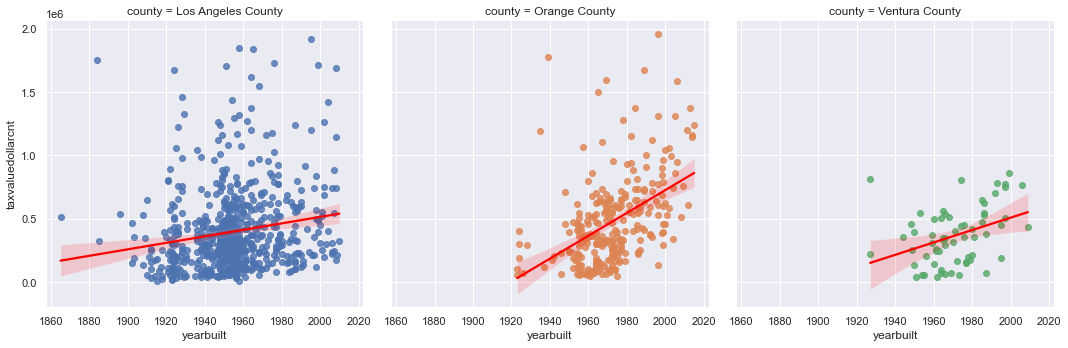

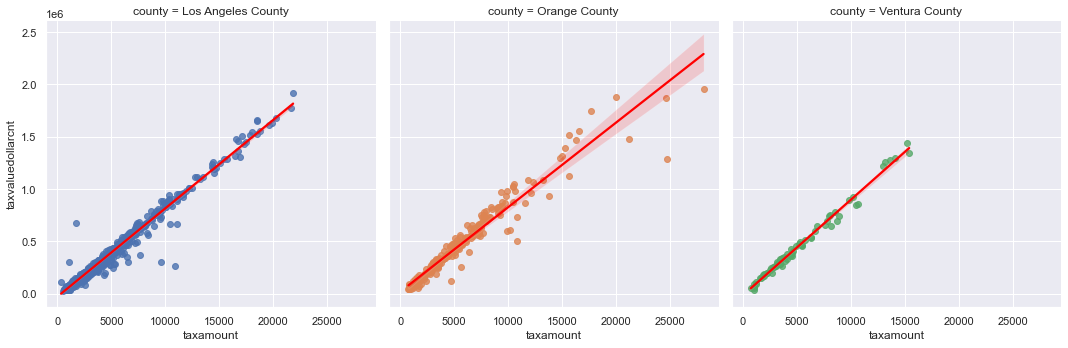

In [17]:
#redo of Exercise 4)
import explore

train=plot_variable_pairs()


AttributeError: 'NoneType' object has no attribute 'sample'

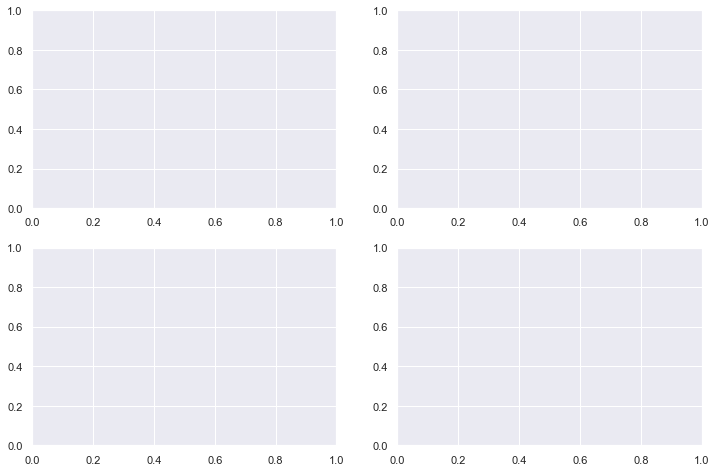

In [19]:
train = plot_categorical_and_continuous_vars()
#not working...even though it does above???